📊 Dataset Overview
- Source: UCI Tetouan Power Consumption Dataset
- Goal: Predict power consumption in 3 urban zones using weather conditions
- Features: Temperature, Humidity, Wind Speed, Solar Radiation, Datetime (timestamped every 10 minutes)

📊 Setup & Exploratory Data Analysis (EDA)

### Step 0 - Import libraries and dataset

In [15]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [16]:
df = pd.read_csv(r"C:\Users\phuon\Development - Hoai Phuong\Making my visual board become true\Dataset\Tetuan City power consumption.csv")
df.head()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


# Step 1 - Data Preprocessing

In [17]:
# Print the format of the dataframe and store wether or not the dataframe contains any missing values
df.info()
value_missing = df.isna().any()
value_missing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DateTime                   52416 non-null  object 
 1   Temperature                52416 non-null  float64
 2   Humidity                   52416 non-null  float64
 3   Wind Speed                 52416 non-null  float64
 4   general diffuse flows      52416 non-null  float64
 5   diffuse flows              52416 non-null  float64
 6   Zone 1 Power Consumption   52416 non-null  float64
 7   Zone 2  Power Consumption  52416 non-null  float64
 8   Zone 3  Power Consumption  52416 non-null  float64
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


DateTime                     False
Temperature                  False
Humidity                     False
Wind Speed                   False
general diffuse flows        False
diffuse flows                False
Zone 1 Power Consumption     False
Zone 2  Power Consumption    False
Zone 3  Power Consumption    False
dtype: bool

##### Observation: There is no missing values in the dataset

- Plot a histogram of the target variable 'Zone 1/2/3 Power Consumption'
This is an important preliminary step to help understand the distribution of the target variable. 

<Figure size 640x480 with 0 Axes>

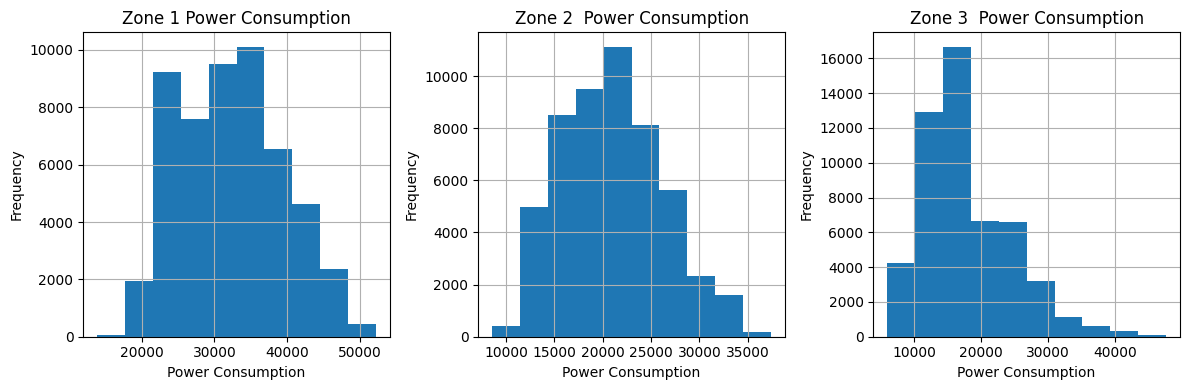

In [ ]:
df_new = df.copy()

# create a figure 
plt.figure()

zone_columns = [
    'Zone 1 Power Consumption',
    'Zone 2  Power Consumption',
    'Zone 3  Power Consumption'
]

plt.figure(figsize=(12, 4)) 

for i, col in enumerate(zone_columns, 1):
    plt.subplot(1, 3, i)
    df_new[col].hist()
    plt.title(col)
    plt.xlabel("Power Consumption")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

Overall observation: 
- Zone 1: The consumption in Zone 1 showed a relatively wide spread, ranging roughly from 15000 to over 50000, with the most common valye clustering between 35000 to 40000. The distribution is fairly symmetric. The extended upper tail indicates that high-consumption events occur more frequently than in other zones. 
- Zone 2: The consummption in zone 2 is more concentrated, generally falling between 10000 and 350000. The distribution is more even than Zone 1 and 3, with less extreme highs.
- Zone 3: Zone 3 exhibits a right-skwed distribution, with most consumption values clustered between 10000 to 20000, but occasional spikes reaching above 40000. 

# 1. Parse the datetime column

In [24]:
df.columns

Index(['DateTime', 'Temperature', 'Humidity', 'Wind Speed',
       'general diffuse flows', 'diffuse flows', 'Zone 1 Power Consumption',
       'Zone 2  Power Consumption', 'Zone 3  Power Consumption'],
      dtype='object')

In [46]:
# Parse into format of datetime
df_new['DateTime'] = pd.to_datetime(df_new['DateTime'], errors = 'coerce')

# Sort the datetime
df_new = df_new.sort_values('DateTime', ascending= True)

# Calculate the time differences between consecutive entries
time_diffs = df_new['DateTime'].diff()
time_diffs


0                   NaT
1       0 days 00:10:00
2       0 days 00:10:00
3       0 days 00:10:00
4       0 days 00:10:00
              ...      
52411   0 days 00:10:00
52412   0 days 00:10:00
52413   0 days 00:10:00
52414   0 days 00:10:00
52415   0 days 00:10:00
Name: DateTime, Length: 52416, dtype: timedelta64[ns]

In [47]:
# The most common frequency
most_common_freq = time_diffs.mode()[0]
print(f"Most commond frequency: ${most_common_freq}")

Most commond frequency: $0 days 00:10:00


In [48]:
# Frequency distribution
freq_counts = time_diffs.value_counts()
print(f"Frequency count: ${freq_counts}")

Frequency count: $DateTime
0 days 00:10:00    52415
Name: count, dtype: int64


In [49]:
inconsistent_rows = df_new.loc[time_diffs != most_common_freq]
inconsistent_rows
print(f"Inconsistent row: ${inconsistent_rows}")

Inconsistent row: $    DateTime  Temperature  Humidity  Wind Speed  general diffuse flows  \
0 2017-01-01        6.559      73.8       0.083                  0.051   

   diffuse flows  Zone 1 Power Consumption  Zone 2  Power Consumption  \
0          0.119                34055.6962                16128.87538   

   Zone 3  Power Consumption  
0                20240.96386  


Observation 2:
- The dataset’s DateTime column spans a continuous time series recorded at exactly 10-minute intervals without any gaps or irregularities. The only “inconsistent” row flagged was the very first entry (2017-01-01), which is expected because it has no preceding timestamp for comparison. This uniform sampling makes the dataset well-suited for time-series modeling without the need for resampling or interpolation.


# 2. Visualize trends in power consumption across zones

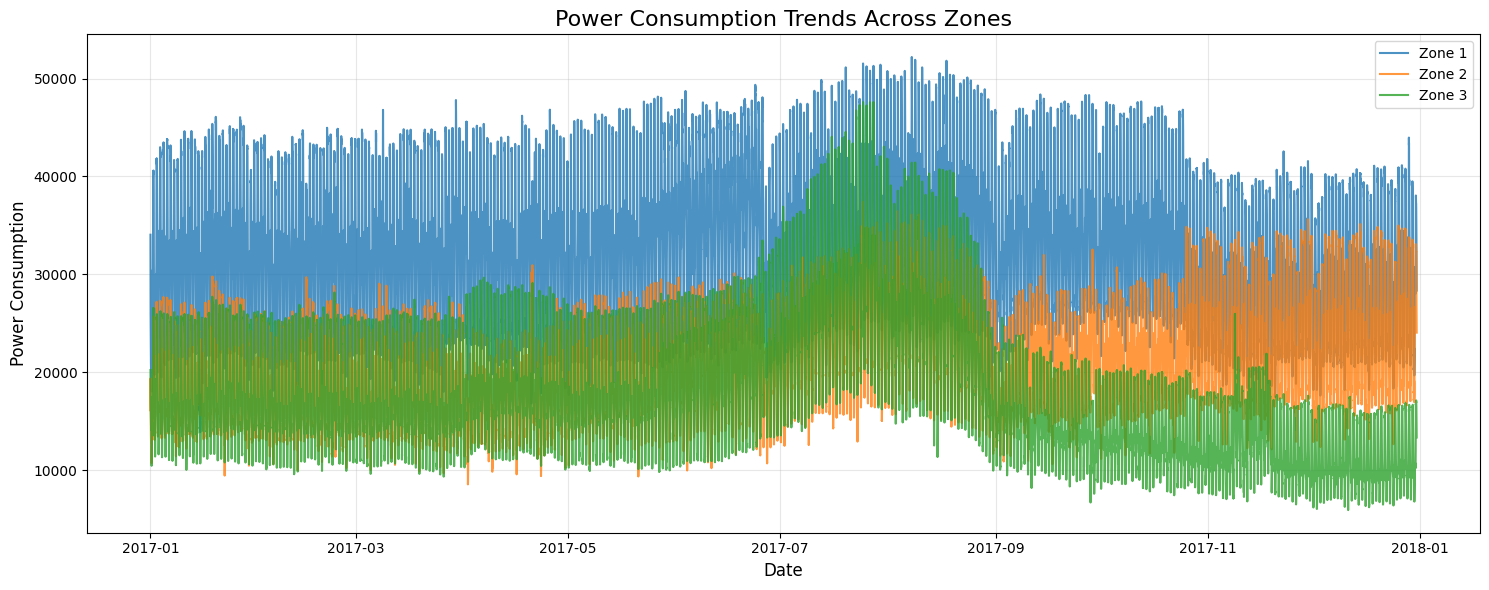

In [50]:
# Reset index to datetime
df_new = df_new.set_index('DateTime')

plt.figure(figsize = (15,6))

plt.plot(df_new.index, df['Zone 1 Power Consumption'], label = 'Zone 1', alpha = 0.8)
plt.plot(df_new.index, df['Zone 2  Power Consumption'], label='Zone 2', alpha=0.8)
plt.plot(df_new.index, df['Zone 3  Power Consumption'], label='Zone 3', alpha=0.8)

plt.title('Power Consumption Trends Across Zones', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Power Consumption', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Observation 3:
- Zone 1 consistently has the highest power consumption, with a stable pattern and moderate seasonal variation. This zone also witness a mild increase in mid summer time from July to September.
- Zone 2 has a lower overall usage, following a smoother pattern.
- Zone 3 witness a generally lower consumption of power except for a sharp summer mspike.

# 3. Compare with environmental features using scatter and line plots

In [57]:
df_new.columns

Index(['Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows',
       'diffuse flows', 'Zone 1 Power Consumption',
       'Zone 2  Power Consumption', 'Zone 3  Power Consumption'],
      dtype='object')

In [ ]:

# Identify features
environemental_features = ['Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows','diffuse flows']
target_features = ['Zone 1 Power Consumption','Zone 2  Power Consumption', 'Zone 3  Power Consumption']

In [63]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)


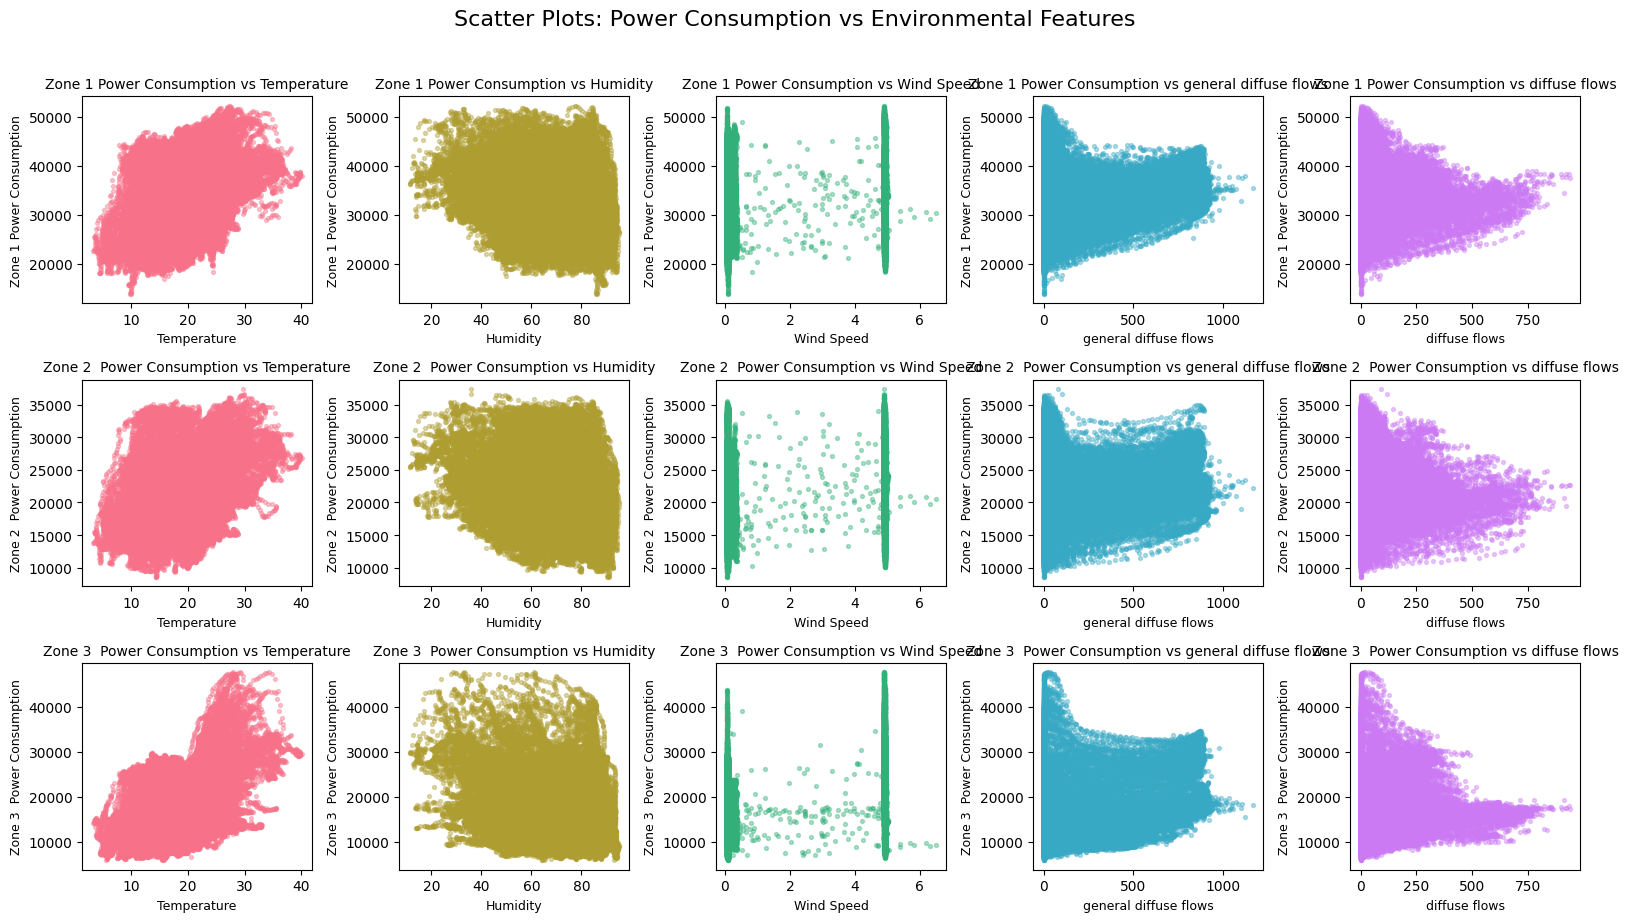

In [67]:
import seaborn as sns

# Use a color palette for variety
colors = sns.color_palette("husl", len(environemental_features))  # husl is colorful and distinct

plt.figure(figsize=(16, 9))
plot_num = 1

for i, zone in enumerate(target_features):
    for j, feature in enumerate(environemental_features):
        plt.subplot(len(target_features), len(environemental_features), plot_num)
        plt.scatter(df_new[feature], df_new[zone], 
                    alpha=0.4, 
                    s=8, 
                    color=colors[j])  # Assign color by feature
        plt.xlabel(feature, fontsize=9)
        plt.ylabel(zone, fontsize=9)
        plt.title(f"{zone} vs {feature}", fontsize=10)
        plot_num += 1

plt.suptitle("Scatter Plots: Power Consumption vs Environmental Features", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Observation 4: 
- For Zone 1, power consumption shows a clear positive relationship with temperature up to around 25°C, after which it levels off, suggesting peak demand in moderately warm conditions. General diffuse flows also show a mild positive association, while diffuse flows tend to correlate negatively with consumption. Humidity and wind speed display no strong relationship, indicating they have little direct influence on Zone 1’s power usage.

- Zone 2: Power consumption increases with temperature up to around 25°C before slightly leveling off, indicating higher demand during moderate warmth. General diffuse flows show a mild positive relationship, while diffuse flows are negatively correlated with consumption. Humidity and wind speed do not display a clear pattern, suggesting little direct influence.
- Zone 3: Consumption rises with temperature, peaking around 30°C before declining, showing a stronger temperature influence than in Zone 2. General diffuse flows have a weak positive relationship, and diffuse flows again show a negative correlation. Humidity and wind speed remain largely uncorrelated with consumption levels.

In [70]:
df_new.columns

Index(['Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows',
       'diffuse flows', 'Zone 1 Power Consumption',
       'Zone 2  Power Consumption', 'Zone 3  Power Consumption'],
      dtype='object')

                           Temperature  Humidity  Wind Speed  \
Temperature                   1.000000 -0.460243    0.477109   
Humidity                     -0.460243  1.000000   -0.135853   
Wind Speed                    0.477109 -0.135853    1.000000   
general diffuse flows         0.460294 -0.468138    0.133733   
diffuse flows                 0.196522 -0.256886   -0.000972   
Zone 1 Power Consumption      0.440221 -0.287421    0.167444   
Zone 2  Power Consumption     0.382428 -0.294961    0.146413   
Zone 3  Power Consumption     0.489527 -0.233022    0.278641   

                           general diffuse flows  diffuse flows  \
Temperature                             0.460294       0.196522   
Humidity                               -0.468138      -0.256886   
Wind Speed                              0.133733      -0.000972   
general diffuse flows                   1.000000       0.564718   
diffuse flows                           0.564718       1.000000   
Zone 1 Power Consumpt

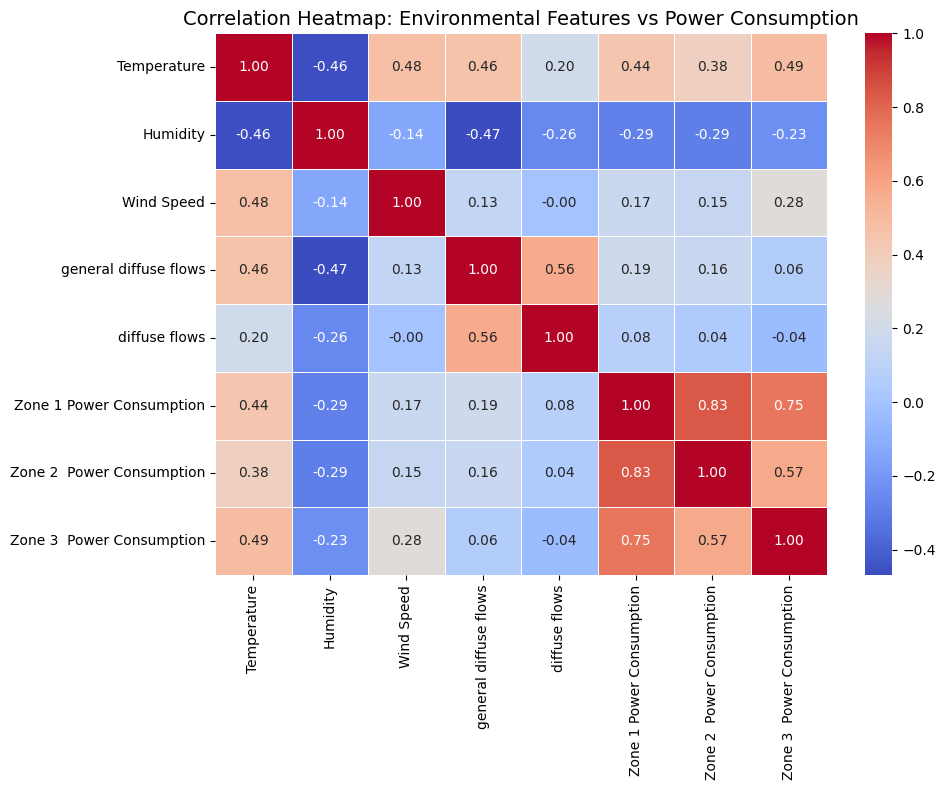

In [71]:
# Compute correlation matrix for all environmental features and power consumption zones
correlation = df_new[[
    'Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows',
       'diffuse flows', 'Zone 1 Power Consumption',
       'Zone 2  Power Consumption', 'Zone 3  Power Consumption'
]].corr()

# Display the correlation matrix
print(correlation)

plt.figure(figsize=(10, 8))  # Adjust size as needed
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap: Environmental Features vs Power Consumption', fontsize=14)
plt.tight_layout()
plt.show()

In [72]:
print(correlation)

                           Temperature  Humidity  Wind Speed  \
Temperature                   1.000000 -0.460243    0.477109   
Humidity                     -0.460243  1.000000   -0.135853   
Wind Speed                    0.477109 -0.135853    1.000000   
general diffuse flows         0.460294 -0.468138    0.133733   
diffuse flows                 0.196522 -0.256886   -0.000972   
Zone 1 Power Consumption      0.440221 -0.287421    0.167444   
Zone 2  Power Consumption     0.382428 -0.294961    0.146413   
Zone 3  Power Consumption     0.489527 -0.233022    0.278641   

                           general diffuse flows  diffuse flows  \
Temperature                             0.460294       0.196522   
Humidity                               -0.468138      -0.256886   
Wind Speed                              0.133733      -0.000972   
general diffuse flows                   1.000000       0.564718   
diffuse flows                           0.564718       1.000000   
Zone 1 Power Consumpt

Observation 5: 

- Temperature exhibits the strongest positive correlation with power usage across all zones.

- Humidity shows a moderate negative correlation in every zone.

- Wind speed has a mild positive correlation in all zones, with the effect being more pronounced in Zone 3.

- Both general diffuse flows and diffuse flows display weak correlations, with slightly positive values observed in Zones 1 and 2.

# 4. Analyze lag effects and missing timestamps

Missing timestamps == = Are we missing any readings in the time series?

- Check if every expected timestamp exists.

- Count and list missing timestamps.

- Decide whether to fill them (e.g., interpolation) or drop affected rows.

Lag effect == How much does past data help predict future values?
- Check if there is autocorrelations
- Calculate autocorrelation and partial autocorrelation plots.
- Identify significant lags to use in forecasting models.

In [78]:
df

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
DateTime,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964
...,...,...,...,...,...,...,...,...
2017-12-30 23:10:00,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212
2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152
2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259


In [81]:
# 1. Check for Missing Timestamps
df_new.reset_index(inplace=True)
df_new.rename(columns={df.columns[0]: 'DateTime'}, inplace=True)

# Create expected full range based on first and last timestamp
full_range = pd.date_range(start=df_new['DateTime'].min(),
                           end=df_new['DateTime'].max(),
                           freq='10T')

# Compare with actual timestamps
missing_timestamps = full_range.difference(df_new['DateTime'])

print(f"Total missing timestamps: {len(missing_timestamps)}")
if len(missing_timestamps) > 0:
    print("Missing timestamps:")
    print(missing_timestamps)

Total missing timestamps: 0


C:\Users\phuon\AppData\Local\Temp\ipykernel_23796\2219313803.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_range = pd.date_range(start=df_new['DateTime'].min(),


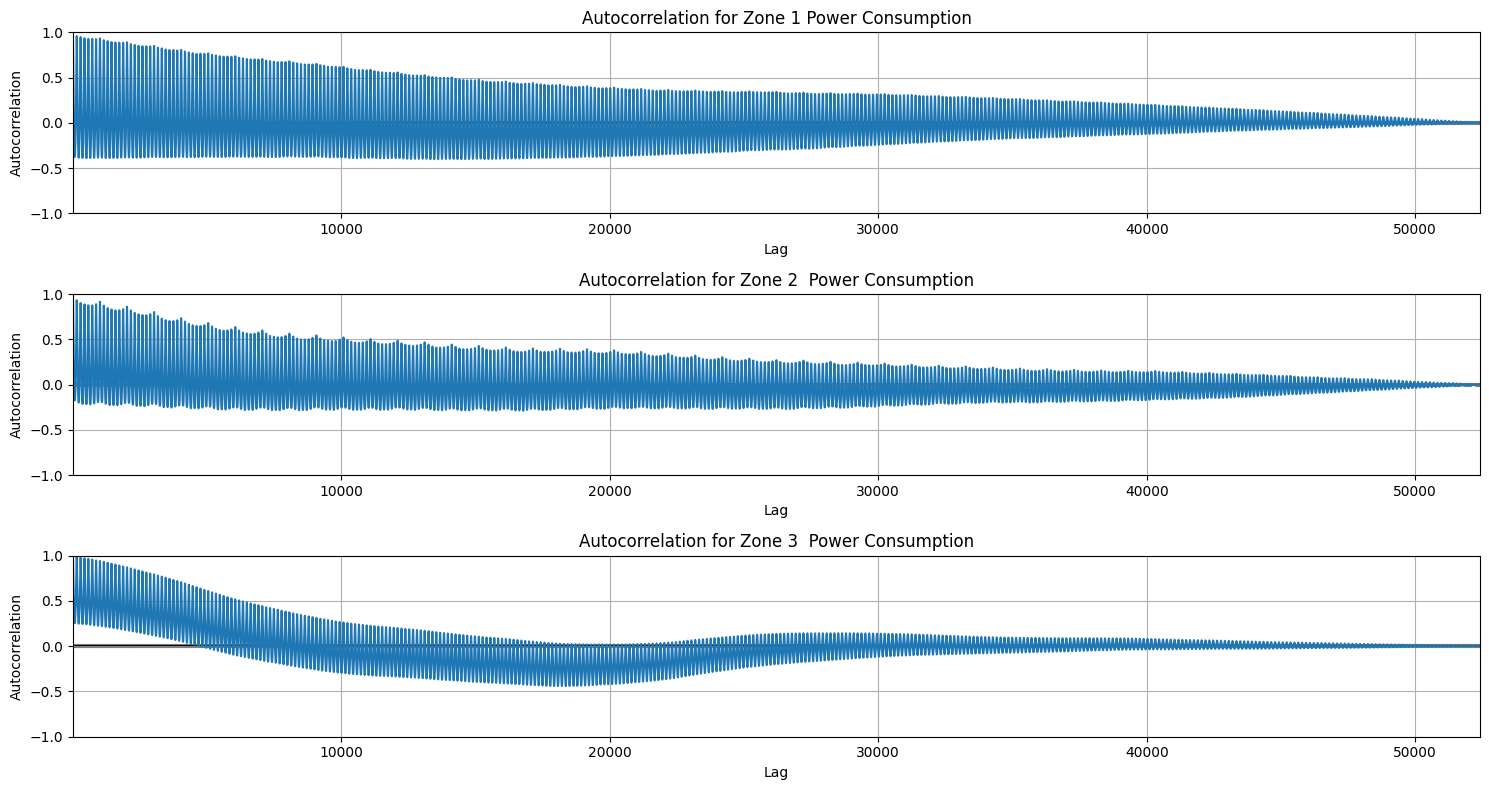

In [82]:
#  2. Analyze Lag Effects
from pandas.plotting import autocorrelation_plot

zones = ['Zone 1 Power Consumption', 'Zone 2  Power Consumption', 'Zone 3  Power Consumption']

plt.figure(figsize=(15, 8))
for i, zone in enumerate(zones, 1):
    plt.subplot(3, 1, i)
    autocorrelation_plot(df_new[zone])
    plt.title(f"Autocorrelation for {zone}")
plt.tight_layout()
plt.show()

Observation 6: 

The autocorrelation charts show how well past power consumption can help predict future usage in each zone. In simple terms, they tell us if past patterns repeat. From these charts, we can see:

- Zone 1 and Zone 2: Their autocorrelation lines slowly shrink and “converge” toward zero in a smooth way. This means the relationship between past and future fades gradually, so the usage patterns are more stable and predictable over long periods.

- Zone 3: Starts at 1.0 like the others but the line drops and wiggles more noticeably. This means the similarity between past and future fades faster, so the usage patterns are less stable and change more unpredictably.